In [152]:
import numpy as np
import pandas as pd
from tensorflow import keras
import requests
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization
from keras.regularizers import l2
from pypfopt import risk_models, BlackLittermanModel, EfficientFrontier, expected_returns
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sb
import yfinance as yf

In [153]:
response = requests.get("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies", verify=False)
raw = pd.read_html(response.text)
fullDF = pd.DataFrame(raw[0])
tickers = fullDF[['Symbol', 'GICS Sector']]
tickers

/Users/sharvfiles/Documents/GitHub/equity-recommender/.venv/lib/python3.12/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'en.wikipedia.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/var/folders/9_/269qc7b913d5dxp67x9ff9vm0000gn/T/ipykernel_41704/3202861573.py:2: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  raw = pd.read_html(response.text)


,Symbol,GICS Sector
0,MMM,Industrials
1,AOS,Industrials
2,ABT,Health Care
3,ABBV,Health Care
4,ACN,Information Technology
...,...,...
498,XYL,Industrials
499,YUM,Consumer Discretionary
500,ZBRA,Information Technology
501,ZBH,Health Care


In [154]:
tickers['Symbol'] = tickers['Symbol'].str.replace('.', '-')
tickers[tickers['Symbol'] == 'BF-B']

sector_breakdown = tickers.groupby('GICS Sector')['Symbol'].apply(list)
sector_breakdown = sector_breakdown.to_dict()

ticker_list = []
for sector in sector_breakdown:
    ticker_list.extend(sector_breakdown[sector])

today = pd.Timestamp.today().strftime('%Y-%m-%d')
month_ago = pd.Timestamp.today() - pd.DateOffset(months=60)

data = yf.download(ticker_list, start=month_ago, end=today)

/var/folders/9_/269qc7b913d5dxp67x9ff9vm0000gn/T/ipykernel_41704/3322520925.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tickers['Symbol'] = tickers['Symbol'].str.replace('.', '-')
[*********************100%***********************]  503 of 503 completed


In [155]:
close_df = data['Close']
close_df.columns = close_df.columns.get_level_values('Ticker')
close_df

Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AFL,AIG,AIZ,AJG,AKAM,ALB,ALGN,ALL,ALLE,AMAT,AMCR,AMD,AME,AMGN,AMP,AMT,AMZN,ANET,ANSS,AON,AOS,APA,APD,APH,APO,...,UNP,UPS,URI,USB,V,VICI,VLO,VLTO,VMC,VRSK,VRSN,VRTX,VST,VTR,VTRS,VZ,WAB,WAT,WBA,WBD,WDAY,WDC,WEC,WELL,WFC,WM,WMB,WMT,WRB,WST,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-02,83.061356,72.796021,72.264908,NaN,79.689934,43.400002,195.263596,334.429993,109.912369,40.693855,153.205902,187.830002,65.907425,77.984421,17.096729,47.437054,45.233276,120.714508,89.824631,87.639999,68.694580,283.679993,99.557999,117.815964,59.500603,8.615149,49.099998,97.476479,207.752930,154.567764,200.433945,94.900497,12.795000,259.589996,200.509750,43.642895,23.035700,206.406876,26.005520,41.134945,...,163.366867,99.478027,165.110245,47.725109,184.838043,19.413031,77.398857,NaN,136.589935,146.433456,196.729996,219.449997,20.040154,46.005966,17.899311,46.334057,78.587166,235.059998,46.284126,32.220001,167.460007,64.771545,77.892303,68.426231,47.053135,105.135826,17.491035,36.782581,27.717844,149.986801,190.670761,24.381454,140.138107,54.000290,56.088295,75.451180,93.090332,139.312683,259.140015,129.208893
2020-01-03,81.727730,72.088287,71.578964,NaN,78.718445,43.349998,194.938416,331.809998,107.977501,40.614422,152.882080,184.949997,65.933418,77.900955,16.900406,47.108059,44.883720,121.289070,89.636520,87.239998,67.710663,280.440002,99.566795,116.359573,58.553555,8.501682,48.599998,97.611847,206.342545,152.640549,200.530411,93.748497,12.553125,256.970001,199.722260,43.259182,23.335453,201.816925,25.734108,40.832863,...,162.210617,99.418388,162.231979,47.168850,183.368042,19.428383,74.461731,NaN,135.996552,147.857864,200.880005,217.979996,20.250732,46.560738,17.509254,45.840748,77.985283,231.009995,46.284126,32.029999,168.440002,63.774597,78.381973,69.630135,46.764244,106.157555,17.565495,36.457859,27.754019,150.382156,190.717468,24.422934,138.059464,54.259991,55.637383,75.895294,92.798759,138.948517,256.049988,129.228149
2020-01-06,81.969337,72.662720,72.143837,NaN,79.130875,43.520000,193.665436,333.709991,106.708908,40.296715,153.088928,187.119995,65.994110,78.159615,17.096729,46.974674,44.918682,121.398529,90.050339,87.550003,67.634964,285.880005,99.858040,116.143486,57.290844,8.444949,48.389999,97.718231,207.925949,153.142914,200.477798,95.143997,12.678750,254.589996,200.298492,43.533260,23.290037,201.727585,25.600782,41.065899,...,160.821381,98.975464,161.908890,46.523922,182.971497,19.228725,74.469872,NaN,135.757339,148.197021,202.740005,224.029999,19.908543,47.042095,18.090010,45.742081,77.664902,228.880005,46.683651,31.959999,169.490005,62.550629,78.442116,70.688881,46.484112,106.709839,17.796326,36.383644,27.713821,150.461227,190.950836,24.373158,137.786194,54.182079,56.064575,75.403938,92.744095,138.145462,258.010010,128.235992
2020-01-07,82.220581,72.320976,71.732277,NaN,78.690971,43.160000,189.484192,333.390015,109.136604,39.811314,151.235962,187.500000,66.236740,78.176331,17.156475,46.530106,44.665245,120.577698,89.081665,90.199997,68.524292,283.059998,99.002045,114.752869,58.945766,8.372008,48.250000,98.279099,205.970413,151.297897,196.205948,95.343002,12.803125,256.670013,198.598663,43.240902,29.530384,202.584885,25.738871,41.109062,...,159.602448,98.805107,161.615158,46.080540,182.487961,19.151932,75.446205,NaN,134.226013,149.437302,203.210007,223.789993,20.031380,46.650486,18.350044,45.233566,77.635773,231.979996,46.448647,32.070000,172.949997,66.785164,78.141434,70.227806,46.098934,106.783478,17.796326,36.046555,27.207378,150.075760,190.558777,24.215542,138.440079,54.069546,55.605728,75.120468,92.908096,138.024078,256.470001,128.669464
2020-01-08,83.032349,73.484344,72.240685,NaN,79.011742,42.730000,189.855896,337.869995,110.122292,39.370041,152.657196,189.949997,66.124092,77.942680,17.122332,46.672359,45.189587,121.033707,89.203896,91.400002,67.341690,286.000000,99.27

In [156]:
daily_returns = close_df.pct_change()
daily_returns_filled = daily_returns.ffill().bfill()
daily_returns_final = daily_returns_filled.reset_index()

In [157]:
daily_returns_final.drop('Date', axis = 1)

Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AFL,AIG,AIZ,AJG,AKAM,ALB,ALGN,ALL,ALLE,AMAT,AMCR,AMD,AME,AMGN,AMP,AMT,AMZN,ANET,ANSS,AON,AOS,APA,APD,APH,APO,...,UNP,UPS,URI,USB,V,VICI,VLO,VLTO,VMC,VRSK,VRSN,VRTX,VST,VTR,VTRS,VZ,WAB,WAT,WBA,WBD,WDAY,WDC,WEC,WELL,WFC,WM,WMB,WMT,WRB,WST,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
0,-0.016056,-0.009722,-0.009492,-0.037731,-0.012191,-0.001152,-0.001665,-0.007834,-0.017604,-0.001952,-0.002114,-0.015333,0.000394,-0.001070,-0.011483,-0.006935,-0.007728,0.004760,-0.002094,-0.004564,-0.014323,-0.011421,0.000088,-0.012362,-0.015917,-0.013171,-0.010183,0.001389,-0.006789,-0.012468,0.000481,-0.012139,-0.018904,-0.010093,-0.003927,-0.008792,0.013013,-0.022237,-0.010437,-0.007344,...,-0.007078,-0.000600,-0.017432,-0.011655,-0.007953,0.000791,-0.037948,-0.043059,-0.004344,0.009727,0.021095,-0.006699,0.010508,0.012059,-0.021792,-0.010647,-0.007659,-0.017230,0.000000,-0.005897,0.005852,-0.015392,0.006286,0.017594,-0.006140,0.009718,0.004257,-0.008828,0.001305,0.002636,0.000245,0.001701,-0.014833,0.004809,-0.008039,0.005886,-0.003132,-0.002614,-0.011924,0.000149
1,-0.016056,-0.009722,-0.009492,-0.037731,-0.012191,-0.001152,-0.001665,-0.007834,-0.017604,-0.001952,-0.002114,-0.015333,0.000394,-0.001070,-0.011483,-0.006935,-0.007728,0.004760,-0.002094,-0.004564,-0.014323,-0.011421,0.000088,-0.012362,-0.015917,-0.013171,-0.010183,0.001389,-0.006789,-0.012468,0.000481,-0.012139,-0.018904,-0.010093,-0.003927,-0.008792,0.013013,-0.022237,-0.010437,-0.007344,...,-0.007078,-0.000600,-0.017432,-0.011655,-0.007953,0.000791,-0.037948,-0.043059,-0.004344,0.009727,0.021095,-0.006699,0.010508,0.012059,-0.021792,-0.010647,-0.007659,-0.017230,0.000000,-0.005897,0.005852,-0.015392,0.006286,0.017594,-0.006140,0.009718,0.004257,-0.008828,0.001305,0.002636,0.000245,0.001701,-0.014833,0.004809,-0.008039,0.005886,-0.003132,-0.002614,-0.011924,0.000149
2,0.002956,0.007968,0.007892,-0.037731,0.005239,0.003922,-0.006530,0.005726,-0.011749,-0.007823,0.001353,0.011733,0.000921,0.003320,0.011616,-0.002831,0.000779,0.000902,0.004617,0.003553,-0.001118,0.019398,0.002925,-0.001857,-0.021565,-0.006673,-0.004321,0.001090,0.007674,0.003291,-0.000262,0.014886,0.010007,-0.009262,0.002885,0.006336,-0.001946,-0.000443,-0.005181,0.005707,...,-0.008564,-0.004455,-0.001992,-0.013673,-0.002163,-0.010277,0.000109,-0.043059,-0.001759,0.002294,0.009259,0.027755,-0.016898,0.010338,0.033168,-0.002152,-0.004108,-0.009220,0.008632,-0.002185,0.006234,-0.019192,0.000767,0.015205,-0.005990,0.005202,0.013141,-0.002036,-0.001448,0.000526,0.001224,-0.002038,-0.001979,-0.001436,0.007678,-0.006474,-0.000589,-0.005780,0.007655,-0.007678
3,0.003065,-0.004703,-0.005705,-0.037731,-0.005559,-0.008272,-0.021590,-0.000959,0.022751,-0.012046,-0.012104,0.002031,0.003677,0.000214,0.003495,-0.009464,-0.005642,-0.006761,-0.010757,0.030268,0.013149,-0.009864,-0.008572,-0.011973,0.028886,-0.008637,-0.002893,0.005740,-0.009405,-0.012048,-0.021308,0.002092,0.009810,0.008170,-0.008486,-0.006716,0.267941,0.004250,0.005394,0.001051,...,-0.007579,-0.001721,-0.001814,-0.009530,-0.002643,-0.003994,0.013110,-0.043059,-0.011280,0.008369,0.002318,-0.001071,0.006170,-0.008325,0.014374,-0.011117,-0.000375,0.013544,-0.005034,0.003442,0.020414,0.067698,-0.003833,-0.006523,-0.008286,0.000690,0.000000,-0.009265,-0.018274,-0.002562,-0.002053,-0.006467,0.004746,-0.002077,-0.008184,-0.003759,0.001768,-0.000879,-0.005969,0.003380
4,0.009873,0.016086,0.007088,-0.037731,0.004076,-0.009963,0.001962,0.013438,0.009032,-0.011084,0.009397,0.013067,-0.001701,-0.002989,-0.001990,0.003057,0.011739,0.003782,0.001372,0.013304,-0.017258,0.010386,0.002763,0.004258,-0.000649,0.003872,-0.008705,0.002263,0.000756,0.008995,0.008673,-0.007809,0.010398,0.004130,0.004110,-0.001479,0.006767,0.005422,0.002405,0.021415,...,0.010951,0.005690,-0.001636,-0.002100,0.017118,0.006416,0.003882,-0.043059,0.007986,0.009208,0.004626,0.032620,0.013140,-0.004897,0.002362,0.001846,-0.017131,-0.024269,-0

In [158]:
tickers

,Symbol,GICS Sector
0,MMM,Industrials
1,AOS,Industrials
2,ABT,Health Care
3,ABBV,Health Care
4,ACN,Information Technology
...,...,...
498,XYL,Industrials
499,YUM,Consumer Discretionary
500,ZBRA,Information Technology
501,ZBH,Health Care


In [159]:
daily_returns_transposed = daily_returns_final.T
daily_returns_transposed.columns = daily_returns_final.index
daily_returns_transposed['Symbol'] = daily_returns_transposed.index

merged_df = pd.merge(daily_returns_transposed, tickers, on='Symbol')
time_series_cols = daily_returns_final.index.tolist()
numeric_data = merged_df[time_series_cols + ['GICS Sector']]
grouped = numeric_data.groupby('GICS Sector').mean()
sector_returns_final = grouped.T
sector_returns_final.head()

GICS Sector,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
0,-0.004384,-0.008091,0.001805,0.002573,-0.0072,-0.010332,-0.00304,-0.009116,-0.015128,0.0088,0.002418
1,-0.004384,-0.008091,0.001805,0.002573,-0.0072,-0.010332,-0.00304,-0.009116,-0.015128,0.0088,0.002418
2,0.006463,-0.001597,0.001408,0.008958,-0.000094,0.006223,-0.001374,-0.000453,-0.006127,0.001387,0.00193
3,0.001352,-0.002542,-0.008324,0.011936,-0.004528,-0.002357,-0.000255,0.007487,-0.001851,-0.011198,0.001763
4,0.006056,0.004369,0.000055,-0.023293,0.005603,0.005402,0.002939,0.005809,0.001676,0.00384,0.002661


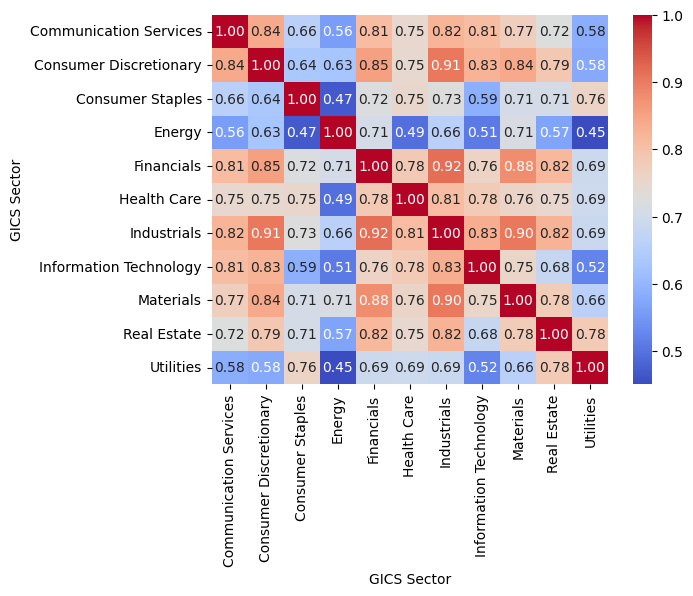

In [160]:
cov = sector_returns_final.corr()

sb.heatmap(cov, annot=True, fmt = '.2f', cmap = 'coolwarm', cbar = True)
plt.show()

In [162]:
sector_returns_final = sector_returns_final.apply(pd.to_numeric, errors='coerce')
sector_returns_final = sector_returns_final.dropna()
sector_returns_final.head()

GICS Sector,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
0,-0.004384,-0.008091,0.001805,0.002573,-0.007200,-0.010332,-0.003040,-0.009116,-0.015128,0.008800,0.002418
1,-0.004384,-0.008091,0.001805,0.002573,-0.007200,-0.010332,-0.003040,-0.009116,-0.015128,0.008800,0.002418
2,0.006463,-0.001597,0.001408,0.008958,-0.000094,0.006223,-0.001374,-0.000453,-0.006127,0.001387,0.001930
3,0.001352,-0.002542,-0.008324,0.011936,-0.004528,-0.002357,-0.000255,0.007487,-0.001851,-0.011198,0.001763
4,0.006056,0.004369,0.000055,-0.023293,0.005603,0.005402,0.002939,0.005809,0.001676,0.003840,0.002661


Epoch 1/40


/Users/sharvfiles/Documents/GitHub/equity-recommender/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.2645 - val_loss: 0.8924
Epoch 2/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.6245 - val_loss: 0.7363
Epoch 3/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.2232 - val_loss: 0.6175
Epoch 4/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.9859 - val_loss: 0.5063
Epoch 5/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.7896 - val_loss: 0.4016
Epoch 6/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.6511 - val_loss: 0.3270
Epoch 7/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.5343 - val_loss: 0.2665
Epoch 8/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.4534 - val_loss: 0.2200
Epoch 9/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.3740 - val_loss: 0.1857
Epoch 10/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.3285 - val_loss: 0.1599
Epoch 11/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2781 - val_loss: 0.1386
Epoch 12/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2425 - val_l

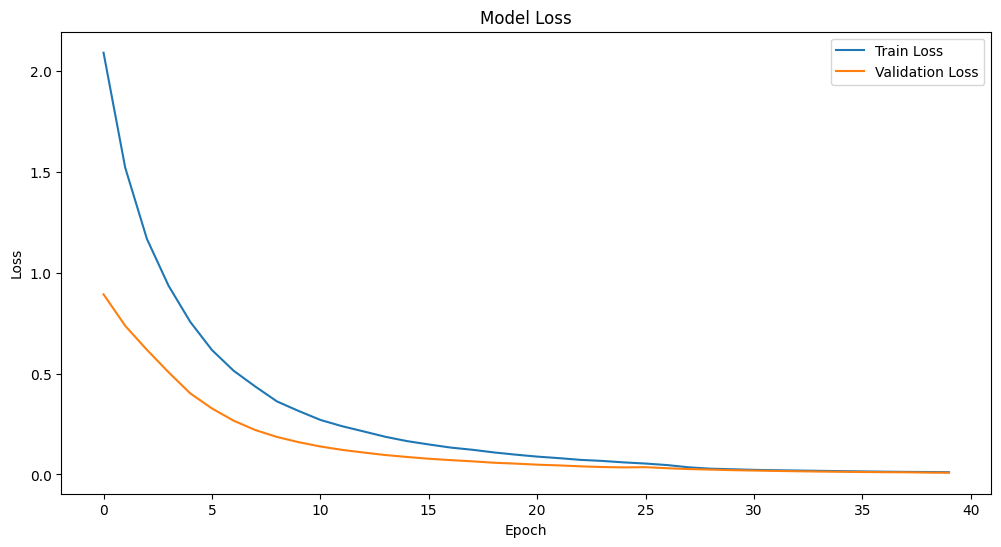

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Mean Squared Error on Test Set: 9.800817479441369e-05


In [163]:
data = sector_returns_final
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 60

X, y = create_sequences(scaled_data, seq_length)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

model = Sequential()
model.add(LSTM(units=30, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), 
               kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(LSTM(units=30, return_sequences=False, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(units=y_train.shape[1])) 
model.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

mse = np.mean(np.square(predictions - scaler.inverse_transform(y_test)))
print(f'Mean Squared Error on Test Set: {mse}')

In [164]:
pred_df = pd.DataFrame(predictions)
pred_df.head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.004761,0.004229,0.002713,0.002106,0.005800,-0.000020,0.002260,0.002933,0.000794,-0.000513,0.001874
1,0.004634,0.004205,0.002649,0.001877,0.005648,-0.000285,0.002008,0.002648,0.000773,-0.000660,0.001620
2,0.004570,0.004228,0.002602,0.001604,0.005620,-0.000531,0.001760,0.002378,0.000627,-0.000892,0.001302
3,0.004369,0.003844,0.002528,0.001189,0.005270,-0.000750,0.001459,0.002260,0.000390,-0.001392,0.001243
4,0.004228,0.003406,0.002441,0.000918,0.004912,-0.001020,0.001166,0.001923,0.000262,-0.001634,0.000986


In [165]:
unique_sectors = tickers['GICS Sector'].unique()
pred_df.columns = unique_sectors

In [173]:
mean_returns = []
for sector in pred_df.columns:
    mean_returns.append(pred_df[sector].mean())
Q = np.array(mean_returns).reshape(-1, 1)

In [174]:
P = np.array([
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
])

In [175]:
pred_df.columns

Index(['Industrials', 'Health Care', 'Information Technology', 'Utilities',
       'Financials', 'Materials', 'Consumer Discretionary', 'Real Estate',
       'Communication Services', 'Consumer Staples', 'Energy'],
      dtype='object')

In [176]:
view_dict = {}
for sector in pred_df.columns:
    for i in range(0, len(mean_returns)):
        view_dict[sector] = mean_returns[i]

view_dict

{'Industrials': np.float32(0.0017463588),
 'Health Care': np.float32(0.0017463588),
 'Information Technology': np.float32(0.0017463588),
 'Utilities': np.float32(0.0017463588),
 'Financials': np.float32(0.0017463588),
 'Materials': np.float32(0.0017463588),
 'Consumer Discretionary': np.float32(0.0017463588),
 'Real Estate': np.float32(0.0017463588),
 'Communication Services': np.float32(0.0017463588),
 'Consumer Staples': np.float32(0.0017463588),
 'Energy': np.float32(0.0017463588)}

In [177]:
bl = BlackLittermanModel(cov_matrix=cov, Q=Q, P=P)
bl.optimize()
bl.portfolio_performance()

/Users/sharvfiles/Documents/GitHub/equity-recommender/.venv/lib/python3.12/site-packages/pypfopt/black_litterman.py:258: UserWarning: Running Black-Litterman with no prior.
  warnings.warn("Running Black-Litterman with no prior.")


(np.float64(0.004588213379096914),
 np.float64(1.5676182781316679),
 np.float64(0.002926869023602658))